# 03 - Use a gridsearch to optimize hyperparameters for Vectorizing and modeling

In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
# TODO more model types can be imported here if interesting

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
# we may choose to only optimize for Tfidf bc this structures the data with more information 
from nltk.corpus import stopwords

In [62]:
posts = pd.read_csv('./data/posts_cleaned.csv')
posts = posts.fillna('')
posts['subreddit'] = posts['subreddit'].map({'TwoXChromosomes': 1, 'MensRights': 0})
posts.tail()

,created_utc,title,self_text,subreddit
5878,2012-12-17 11:09:52,The Physical and Psychological Differences Bet...,,0
5879,2012-12-06 12:14:14,FB yielded a good example of the double standa...,,0
5880,2012-11-04 04:44:44,Incident at work today (not a discrimination i...,So I work as a car salesman and today a well e...,0
5881,2019-04-28 20:05:06,"As a woman,","I really want to support your movement, and i ...",0
5882,2023-05-17 14:27:51,"""Dead-Beat Dads"" is a myth....","A long time ago, I copied something I found o...",0


In [63]:
posts.isnull().sum() # confirm data contains no null values

created_utc    0
title          0
self_text      0
subreddit      0
dtype: int64

In [64]:
# engineer a new feature that combines title and self text 'all_text'
# because oftentimes posts have no text body, and the title contains all the information
posts['all_text'] = posts['title'] + '\n\n' + posts['self_text']
posts['all_text']

0       What are some fashion choices men have given y...
1       I feel insane - IUD stories? \n\nHi all, I hav...
2       questions for anyone with the birth control ar...
3       Running Through Fear: Kosovar Women Jog In Gro...
4       I’m so sick of the low effort men put into the...
                              ...                        
5878    The Physical and Psychological Differences Bet...
5879    FB yielded a good example of the double standa...
5880    Incident at work today (not a discrimination i...
5881    As a woman,\n\nI really want to support your m...
5882    "Dead-Beat Dads" is a myth....\n\n A long time...
Name: all_text, Length: 5883, dtype: object

In [65]:
dropped = posts.drop(columns=['title', 'self_text'])


dropped = dropped[['created_utc', 'all_text', 'subreddit']]
dropped.head()
dropped.to_csv('./data/posts_cleaned.csv', index=False)

In [75]:
# Start from here
posts = pd.read_csv('./data/posts_cleaned.csv')
posts.head()

,created_utc,all_text,subreddit
0,2024-03-01 08:30:47,What are some fashion choices men have given y...,1
1,2024-03-01 07:56:51,"I feel insane - IUD stories? \n\nHi all, I hav...",1
2,2024-03-01 06:30:16,questions for anyone with the birth control ar...,1
3,2024-03-01 06:30:07,Running Through Fear: Kosovar Women Jog In Gro...,1
4,2024-03-01 06:22:10,I’m so sick of the low effort men put into the...,1


In [76]:
posts.subreddit.mean() # 0.50 means balanced classes which is good for binary classification

0.504164541900391

In [77]:
X = posts['all_text']
y = posts['subreddit']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [78]:
# Set up a pipeline with two stages:
# 1. CountVectorizer (transformer)
# 2. Multinomial Naive Bayes (estimator)

# Given the warning in CountVectorizer that their stop_words for 'english' are not great, we use the nltk library stop_words
sw = stopwords.words('english')

pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())
])

params = {
    'cvec__stop_words' :[None, sw],
    # 'cvec__binary': [False, True],
    'cvec__min_df': [1, 2],
    # 'cvec__max_df: [0.98]
    'cvec__ngram_range': [(1, 1), (1, 2), (2, 3)],
    'cvec__max_features': [1000, 2000, 3000, None],
}

gs = GridSearchCV(pipe, params, n_jobs=8)

In [81]:
%%time
gs.fit(X_train, y_train)

CPU times: user 2.65 s, sys: 432 ms, total: 3.08 s
Wall time: 1min 27s


GridSearchCV(estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('nb', MultinomialNB())]),
             n_jobs=8,
             param_grid={'cvec__max_features': [1000, 2000, 3000, None],
                         'cvec__min_df': [1, 2],
                         'cvec__ngram_range': [(1, 1), (1, 2), (2, 3)],
                         'cvec__stop_words': [None,
                                              ['i', 'me', 'my', 'myself', 'we',
                                               'our', 'ours', 'ourselves',
                                               'you', "you're", "you've",
                                               "you'll", "you'd", 'your',
                                               'yours', 'yourself',
                                               'yourselves', 'he', 'him', 'his',
                                               'himself', 'she', "she's", 'her',
                                               'hers', 'herself', 'it', "it's",
                                               'its', 'itself', ...]]})

In [82]:
# HERE
gs.best_params_

{'cvec__max_features': None,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 2),
 'cvec__stop_words': ['i',
  'me',
  'my',
  'myself',
  'we',
  'our',
  'ours',
  'ourselves',
  'you',
  "you're",
  "you've",
  "you'll",
  "you'd",
  'your',
  'yours',
  'yourself',
  'yourselves',
  'he',
  'him',
  'his',
  'himself',
  'she',
  "she's",
  'her',
  'hers',
  'herself',
  'it',
  "it's",
  'its',
  'itself',
  'they',
  'them',
  'their',
  'theirs',
  'themselves',
  'what',
  'which',
  'who',
  'whom',
  'this',
  'that',
  "that'll",
  'these',
  'those',
  'am',
  'is',
  'are',
  'was',
  'were',
  'be',
  'been',
  'being',
  'have',
  'has',
  'had',
  'having',
  'do',
  'does',
  'did',
  'doing',
  'a',
  'an',
  'the',
  'and',
  'but',
  'if',
  'or',
  'because',
  'as',
  'until',
  'while',
  'of',
  'at',
  'by',
  'for',
  'with',
  'about',
  'against',
  'between',
  'into',
  'through',
  'during',
  'before',
  'after',
  'above',
  'below',
  'to',
  'from',
  '

In [94]:
pd.DataFrame(gs.cv_results_).sort_values('mean_test_score', ascending=False)[:5]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_cvec__max_features,param_cvec__min_df,param_cvec__ngram_range,param_cvec__stop_words,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
45,1.662108,0.046407,0.315968,0.024438,None,2,"(1, 2)","[i, me, my, myself, we, our, ours, ourselves, ...","{'cvec__max_features': None, 'cvec__min_df': 2...",0.796149,0.785957,0.775510,0.780045,0.757370,0.779006,0.012835,1
37,0.795656,0.065643,0.195494,0.037923,None,1,"(1, 1)","[i, me, my, myself, we, our, ours, ourselves, ...","{'cvec__max_features': None, 'cvec__min_df': 1...",0.781427,0.761042,0.773243,0.786848,0.767574,0.774027,0.009274,2
44,2.180487,0.043091,0.441617,0.013911,None,2,"(1, 2)",None,"{'cvec__max_features': None, 'cvec__min_df': 2...",0.785957,0.763307,0.776644,0.770975,0.751701,0.769717,0.011653,3
43,0.698712,0.009899,0.160617,0.013307,None,2,"(1, 1)","[i, me, my, myself, we, our, ours, ourselves, ...","{'cvec__max_features': None, 'cvec__min_df': 2...",0.775764,0.758777,0.769841,0.784580,0.753968,0.768586,0.011125,4
33,2.083121,0.068231,0.282956,0.011873,3000,2,"(1, 2)","[i, me, my, myself, we, our, ours, ourselves, ...","{'cvec__max_features': 3000, 'cvec__min_df': 2...",0.770102,0.761042,0.765306,0.773243,0.748299,0.763598,0.008704,5


In [83]:
gs.score(X_train, y_train)

0.8785131459655485

In [84]:
gs.score(X_test, y_test)

0.7824609109449354

In [34]:
y_hat = gs.predict(X_test)
confusion_matrix(y_test, y_hat)

array([[551, 163],
       [173, 584]])

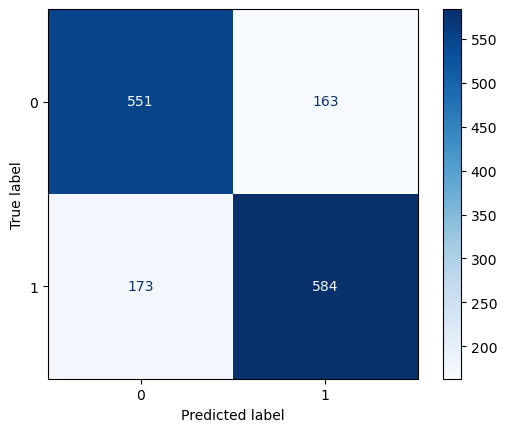

In [35]:
ConfusionMatrixDisplay.from_estimator(gs, X_test, y_test, cmap='Blues');

This model is bad.  Discuss the accuracy, specificity, sensitivity, precision here.

In [36]:
# Examine the best params
gs.best_params_

{'cvec__min_df': 1,
 'cvec__ngram_range': (1, 1),
 'cvec__stop_words': ['i',
  'me',
  'my',
  'myself',
  'we',
  'our',
  'ours',
  'ourselves',
  'you',
  "you're",
  "you've",
  "you'll",
  "you'd",
  'your',
  'yours',
  'yourself',
  'yourselves',
  'he',
  'him',
  'his',
  'himself',
  'she',
  "she's",
  'her',
  'hers',
  'herself',
  'it',
  "it's",
  'its',
  'itself',
  'they',
  'them',
  'their',
  'theirs',
  'themselves',
  'what',
  'which',
  'who',
  'whom',
  'this',
  'that',
  "that'll",
  'these',
  'those',
  'am',
  'is',
  'are',
  'was',
  'were',
  'be',
  'been',
  'being',
  'have',
  'has',
  'had',
  'having',
  'do',
  'does',
  'did',
  'doing',
  'a',
  'an',
  'the',
  'and',
  'but',
  'if',
  'or',
  'because',
  'as',
  'until',
  'while',
  'of',
  'at',
  'by',
  'for',
  'with',
  'about',
  'against',
  'between',
  'into',
  'through',
  'during',
  'before',
  'after',
  'above',
  'below',
  'to',
  'from',
  'up',
  'down',
  'in',
  'out

In [37]:
sw

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [38]:
gs.best_estimator_

Pipeline(steps=[('cvec',
                 CountVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...])),
                ('nb', MultinomialNB())])

In [39]:
gs.best_index_

1

In [40]:
gs.best_score_

0.7740266510530222

The model is bad.  But the best estimator in this gridsearch removed stopwords, so we keep it in the model.  Or, rather, let's build this up from smaller grid searches. Or, utitilzie random search to cover hyperparamter space more efficiently.

In [41]:
# Given the warning in CountVectorizer that their stop_words for 'english' are not great, we use the nltk library stop_words
sw = stopwords.words('english')

pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())
])

params = {
    'cvec__stop_words' :[sw],
    # 'cvec__binary': [False, True],
    'cvec__min_df': [1, 2],
    # 'cvec__max_df: [0.98]
    'cvec__ngram_range': [(1,1), (1,2), (1, 3)],
    # 'cvec__max_features': [2000, 3000, None],
}

gs = GridSearchCV(pipe, params, n_jobs=4)

In [43]:
%%time
gs.fit(X_train, y_train)

CPU times: user 1.14 s, sys: 247 ms, total: 1.39 s
Wall time: 11.4 s


GridSearchCV(estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('nb', MultinomialNB())]),
             n_jobs=4,
             param_grid={'cvec__min_df': [1, 2],
                         'cvec__ngram_range': [(1, 1), (1, 2), (1, 3)],
                         'cvec__stop_words': [['i', 'me', 'my', 'myself', 'we',
                                               'our', 'ours', 'ourselves',
                                               'you', "you're", "you've",
                                               "you'll", "you'd", 'your',
                                               'yours', 'yourself',
                                               'yourselves', 'he', 'him', 'his',
                                               'himself', 'she', "she's", 'her',
                                               'hers', 'herself', 'it', "it's",
                                               'its', 'itself', ...]]})

In [44]:
gs.score(X_train, y_train)

0.8785131459655485

In [46]:
gs.score(X_test, y_test)

0.7824609109449354

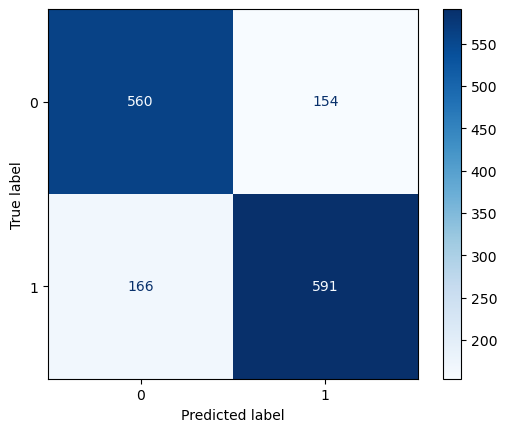

In [45]:
ConfusionMatrixDisplay.from_estimator(gs, X_test, y_test, cmap='Blues');

In [48]:
gs.best_params_

{'cvec__min_df': 2,
 'cvec__ngram_range': (1, 2),
 'cvec__stop_words': ['i',
  'me',
  'my',
  'myself',
  'we',
  'our',
  'ours',
  'ourselves',
  'you',
  "you're",
  "you've",
  "you'll",
  "you'd",
  'your',
  'yours',
  'yourself',
  'yourselves',
  'he',
  'him',
  'his',
  'himself',
  'she',
  "she's",
  'her',
  'hers',
  'herself',
  'it',
  "it's",
  'its',
  'itself',
  'they',
  'them',
  'their',
  'theirs',
  'themselves',
  'what',
  'which',
  'who',
  'whom',
  'this',
  'that',
  "that'll",
  'these',
  'those',
  'am',
  'is',
  'are',
  'was',
  'were',
  'be',
  'been',
  'being',
  'have',
  'has',
  'had',
  'having',
  'do',
  'does',
  'did',
  'doing',
  'a',
  'an',
  'the',
  'and',
  'but',
  'if',
  'or',
  'because',
  'as',
  'until',
  'while',
  'of',
  'at',
  'by',
  'for',
  'with',
  'about',
  'against',
  'between',
  'into',
  'through',
  'during',
  'before',
  'after',
  'above',
  'below',
  'to',
  'from',
  'up',
  'down',
  'in',
  'out

In [49]:
# Given the warning in CountVectorizer that their stop_words for 'english' are not great, we use the nltk library stop_words
sw = stopwords.words('english')

pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())
])

params = {
    'cvec__stop_words' :[None],
    # 'cvec__binary': [False, True],
    'cvec__min_df': [1, 2],
    # 'cvec__max_df: [0.98]
    'cvec__ngram_range': [ (1,2)],
    'cvec__max_features': [2000, 3000, None],
}

gs = GridSearchCV(pipe, params, n_jobs=4)

In [50]:
%%time
gs.fit(X_train, y_train)

CPU times: user 1.46 s, sys: 190 ms, total: 1.65 s
Wall time: 14 s


GridSearchCV(estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('nb', MultinomialNB())]),
             n_jobs=4,
             param_grid={'cvec__max_features': [2000, 3000, None],
                         'cvec__min_df': [1, 2], 'cvec__ngram_range': [(1, 2)],
                         'cvec__stop_words': [None]})

In [51]:
gs.best_params_

{'cvec__max_features': None,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 2),
 'cvec__stop_words': None}

In [52]:
gs.score(X_train, y_train)

0.8712601994560291

In [53]:
gs.score(X_test, y_test)

0.769544527532291